In [638]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
import networkx as nx
import matplotlib.pyplot as plt

In [639]:
stations = ['A', 'B', 'C', 'D', 'E', 'S1', 'S2']
transitions = {
    'S1': ['A', 'B', 'C'],
    'S2': ['A', 'B', 'C', 'D', 'E']
}

In [640]:
vagon_type = ['A', 'B', 'C']
lacomotive_type = ['S1', 'S2']

vagon_list = [
    {
        'st': 'A',
        'type': 'A',
    },
    {
        'st': 'A',
        'type': 'B',
    },
    {
        'st': 'A',
        'type': 'A',
    },
    {
        'st': 'A',
        'type': 'B',
    },
    {
        'st': 'A',
        'type': 'B',
    },
    {
        'st': 'A',
        'type': 'A',
    },
    {
        'st': 'B',
        'type': 'B',
    },
    {
        'st': 'B',
        'type': 'C',
    },
    {
        'st': 'B',
        'type': 'B',
    },
    {
        'st': 'C',
        'type': 'A',
    },
    {
        'st': 'C',
        'type': 'B',
    },
    {
        'st': 'C',
        'type': 'B',
    },
    {
        'st': 'D',
        'type': 'A',
    },
    {
        'st': 'D',
        'type': 'B',
    },
    {
        'st': 'E',
        'type': 'B',
    },
    {
        'st': 'E',
        'type': 'A',
    },
    {
        'st': 'E',
        'type': 'A',
    },
]

In [641]:
G = nx.Graph()
color_map = []
color_nodes = ['orange' for _ in range(len(stations))] + ['green' for _ in range(len(vagon_list))]

for key, value in transitions.items():
    for val in value:
        G.add_edge(key, val, color='b', weight=3)
        color_map.append('orange')

for i in range(len(vagon_list)):
    G.add_edge(vagon_list[i]['st'], f"{i}: {vagon_list[i]['type']}", color='g', weight=1, capacity=15)
    color_map.append('blue')

{'S1': Text(-0.39463489500456517, -0.05310106911566992, 'S1'),
 'A': Text(-0.28338410104160394, 0.6816885724535457, 'A'),
 'B': Text(-0.7764882751759181, -0.3306332337201945, 'B'),
 'C': Text(-0.037878524573182, -0.7529931853805854, 'C'),
 'S2': Text(0.07626834688084479, -0.04545450737489096, 'S2'),
 'D': Text(0.7235869360639728, -0.4806321182723049, 'D'),
 'E': Text(0.7910583998899292, 0.3601786972293804, 'E'),
 '0: A': Text(-0.07743121263156837, 0.7686934182241201, '0: A'),
 '1: B': Text(-0.22052876013076272, 0.8991074331331218, '1: B'),
 '2: A': Text(-0.41888933366274567, 0.8614103276950487, '2: A'),
 '3: B': Text(-0.5122445620261447, 0.6907769265519458, '3: B'),
 '4: B': Text(-0.40295422266833286, 0.5211482311147004, '4: B'),
 '5: A': Text(-0.13120500982878872, 0.5601717434608894, '5: A'),
 '6: B': Text(-0.9255060381670873, -0.1755188853257004, '6: B'),
 '7: C': Text(-0.9831687070753077, -0.4236987317114074, '7: C'),
 '8: B': Text(-0.7543531099128689, -0.5404082061521231, '8: B'),


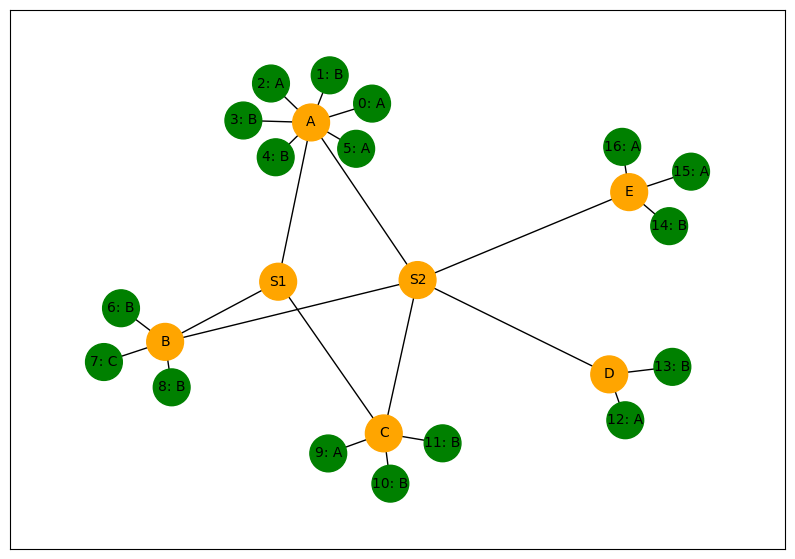

In [642]:
plt.figure(figsize =(10, 7))

pos = nx.kamada_kawai_layout(G,)
nx.draw_networkx_nodes(G, pos, node_size=700, margins=0.1, node_color=color_nodes)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

In [643]:
# 0 - простой
# 1 - перевести на другую ветку
# 2 - присоединить вагон
# 3 - отсоединить вагон

operations_cost = [10, 15, 2, 2]

In [644]:
VAGON_COUNT = 17
MAX_OPERATIONS = 10
LENGTH_CHROM = VAGON_COUNT * MAX_OPERATIONS     # длина хромосомы, подлежащей оптимизации
TRAIN_LIVE_TIME = {
    'S1': 5,
    'S2': 6
}
 
# константы генетического алгоритма
POPULATION_SIZE = 300   # количество индивидуумов в популяции
P_CROSSOVER = 0.9       # вероятность скрещивания
P_MUTATION = 0.2        # вероятность мутации индивидуума
MAX_GENERATIONS = 10000    # максимальное количество поколений
HALL_OF_FAME_SIZE = 3

In [645]:
RANDOM_SEED = 0
random.seed(RANDOM_SEED)

In [646]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

/home/atikin/anaconda3/envs/dataAnalytics/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/atikin/anaconda3/envs/dataAnalytics/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [647]:
def create_random_list(max_range, count):
    operations_count = random.randint(1, count)
    res = {
        'index': 0,
        'start_station': None,
        'commands': []
    }
    for _ in range(count):
        if operations_count > 0:
            new_oper = random.randint(0, max_range)
            if new_oper == 1:
                state = random.choice(['A', 'B', 'C', 'D', 'E', 'S1', 'S2'])
                res['commands'].append({f'{new_oper}': state})
            else:
                res['commands'].append({f'{new_oper}': None})
        else:
            res['commands'].append({'0': None})
        operations_count -= 1
    return res

In [648]:
create_random_list(4, MAX_OPERATIONS)

{'index': 0,
 'start_station': None,
 'commands': [{'3': None},
  {'0': None},
  {'2': None},
  {'4': None},
  {'3': None},
  {'3': None},
  {'2': None},
  {'0': None},
  {'0': None},
  {'0': None}]}

In [649]:
toolbox = base.Toolbox()
toolbox.register("randomOper", create_random_list, len(operations_cost) - 1, MAX_OPERATIONS)
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.randomOper, len(vagon_list))
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [650]:
population = toolbox.populationCreator(n=len(vagon_list))

In [651]:
# расставляем в каждый ген id поезда и его начальную станцию

for i in range(len(population)):
    for j in range(len(population[i])):
        population[i][j]['index'] = j
        population[i][j]['start_station'] = vagon_list[j]['st']

In [652]:
# 0 - простой
# 1 - перевести на другую ветку
# 2 - присоединить вагон
# 3 - отсоединить вагон

def unhook_check(commands: list, curr_step: int) -> bool:
    for i in range(curr_step-1, -1, -1):
        for key, _ in commands[i].items():
            if key == '3': return False
            if key == '2': return True
    return True

def hook_check(commands: list, curr_step: int) -> bool:
    for i in range(curr_step-1, -1, -1):
        for key, _ in commands[i].items():
            if key == '2': return False
            if key == '3': return True
    return False

def move_check(commands: list, curr_step: int) -> bool:
    for i in range(curr_step-1, -1, -1):
        for key, _ in commands[i].items():
            if key == '2': return False
            if key == '3': return True
    return False

def train_leave_check(commands: list, curr_step: int) -> (bool, bool):
    "(bool, bool) = (надо ли считать стоимость, надо ли выписать штраф)"
    for train in TRAIN_LIVE_TIME.keys():
        if curr_step < TRAIN_LIVE_TIME[train]: return (True, False)
        for i in range(curr_step-1, -1, -1):
            for key, val in commands[i].items():
                if key == '1' and val == train and TRAIN_LIVE_TIME[train] >= i: return (False, False)
                if key == '1' and val == train and TRAIN_LIVE_TIME[train] < i: return (False, True)
                if key != '0': return (False, True)
    return (True, False)

In [653]:
PENALITY_COST = max(operations_cost) * 10  # штраф за запрещенную операцию

def shedule_cost(individual):
    current_cost = 0

    # print("cost--------------")
    
    for vagon_id in range(len(individual)):
        # print(f"vagon_id = {vagon_id}")
        commands = individual[vagon_id]['commands']
        # print(f"commands = {commands}")
        for i in range(len(commands)):
            command = commands[i]
            for key, val in command.items():
                train_check = train_leave_check(commands, i)

                # проверка на то, что отцепили (перед отцепкой, последняя операйия должна быть "прицепка" или не было никаких операций, кроме ожидания)
                if key == '3' and unhook_check(commands, i) is False:
                    current_cost += PENALITY_COST
                elif key == '2' and hook_check(commands, i) is False: # проверка на то, что прицепили (перед прицепом, в пред операциях должна быть отцепка, а между ними либо простой либо перегонка)
                    current_cost += PENALITY_COST
                elif key == '1' and move_check(commands, i) is False: # проверка на перегонку (сначала должны были отцепить. Между ними могут быть только операции простоя. И нельзя перегнать на ту ветку, на которой стоишь)
                    current_cost += PENALITY_COST
                elif train_check == (False, False): # проверка на отправку поезда, если он в нем
                    current_cost += 0
                elif train_check[1] == True:
                    current_cost += PENALITY_COST
                else:
                    current_cost += operations_cost[int(key)]
        # print(f"cost = {current_cost}")
    return current_cost,

In [654]:
shedule_cost(population[0])

(15752,)

In [655]:
def mate(ind1, ind2):
    chande_index_count = random.randint(0, len(ind1)//2)  # выбираем количество индексов для перемешивания. Не более половины
    indexes_for_change = random.sample(range(len(ind1)), chande_index_count)  # определили индексы для перемешивания

    for i in indexes_for_change:
        ind1[i], ind2[i] = ind2[i], ind1[i]  # меняем местами определенные ячейким расписания

    return ind1, ind2

In [656]:
def mut(individual, indpb):
    chande_index_count = random.randint(0, len(individual))
    ids_for_mut = random.sample(range(len(individual)), chande_index_count)
    for i in ids_for_mut:
        change_index_count = random.randint(0, len(individual[i]['commands']) - 1)
        new_oper = random.randint(0, len(operations_cost) - 1)
        if new_oper == 1:
            state = random.choice(['A', 'B', 'C', 'D', 'E', 'S1', 'S2'])
            individual[i]['commands'][change_index_count] = {f'{new_oper}': state}
        else:
            individual[i]['commands'][change_index_count] = {f'{new_oper}': None}
 
    return individual,

In [657]:
toolbox.register("evaluate", shedule_cost)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", mate)
toolbox.register("mutate", mut, indpb=1.0/LENGTH_CHROM/10)

In [658]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

In [659]:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

In [660]:
population, logbook = algorithms.eaSimple(population, toolbox,
                                        cxpb=P_CROSSOVER/VAGON_COUNT,
                                        mutpb=P_MUTATION/VAGON_COUNT,
                                        ngen=MAX_GENERATIONS,
                                        halloffame=hof,
                                        stats=stats,
                                        verbose=True)

gen	nevals	min  	avg    
0  	17    	14845	16639.4
1  	0     	14845	15951.6
2  	0     	14845	15578.1
3  	0     	14845	14971.5
4  	2     	14845	14870.3
5  	2     	14845	14845  
6  	0     	14845	14845  
7  	2     	14845	14845  
8  	3     	14845	14853.5
9  	2     	14845	14845  
10 	4     	14845	14845  
11 	2     	14845	14845  
12 	0     	14845	14845  
13 	0     	14845	14845  
14 	0     	14845	14845  
15 	0     	14845	14845  
16 	0     	14845	14845  
17 	1     	14845	14894.4
18 	4     	14845	14845  
19 	2     	14845	14845  
20 	2     	14845	14845  
21 	0     	14845	14845  
22 	0     	14845	14845  
23 	0     	14845	14845  
24 	1     	14549	14827.6
25 	2     	14549	14792.8
26 	0     	14549	14723.1
27 	0     	14549	14618.6
28 	0     	14549	14566.4
29 	2     	14549	14549  
30 	0     	14549	14549  
31 	0     	14549	14549  
32 	2     	14549	14549  
33 	0     	14549	14549  
34 	4     	14549	14549  
35 	1     	14549	14565.3
36 	1     	14549	14591.1
37 	1     	13817	14505.9
38 	0     	13817	14419.8


51 	2     	13801	13801  
52 	2     	13801	13801  
53 	0     	13801	13801  
54 	0     	13801	13801  
55 	1     	13801	13884.6
56 	2     	13801	13801  
57 	2     	13801	13801  
58 	2     	13801	13801  
59 	0     	13801	13801  
60 	3     	13801	13919.5
61 	1     	13801	13826.1
62 	0     	13801	13801  
63 	0     	13801	13801  
64 	2     	13801	13801  
65 	1     	13801	13825.7
66 	0     	13801	13801  
67 	0     	13801	13801  
68 	2     	13801	13801  
69 	5     	13801	13854.5
70 	0     	13801	13801  
71 	2     	13801	13801  
72 	5     	13801	13842.2
73 	1     	13801	13817.2
74 	0     	13801	13801  
75 	0     	13801	13801  
76 	2     	13801	13801  
77 	0     	13801	13801  
78 	0     	13801	13801  
79 	0     	13801	13801  
80 	0     	13801	13801  
81 	0     	13801	13801  
82 	0     	13801	13801  
83 	0     	13801	13801  
84 	0     	13801	13801  
85 	1     	13801	13817  
86 	0     	13801	13801  
87 	2     	13801	13801  
88 	2     	13801	13801  
89 	1     	13801	13801.6
90 	0     	13801	13801  


In [661]:
maxFitnessValues, meanFitnessValues = logbook.select("min", "avg")

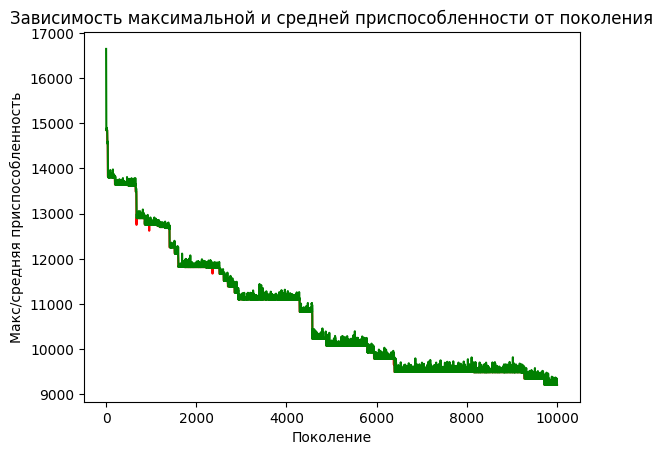

In [662]:
plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Поколение')
plt.ylabel('Макс/средняя приспособленность')
plt.title('Зависимость максимальной и средней приспособленности от поколения')
 
plt.show()

In [663]:
for vagon in hof.items[0]:
    print(vagon)

{'index': 0, 'start_station': 'A', 'commands': [{'0': None}, {'0': None}, {'3': None}, {'0': None}, {'2': None}, {'1': 'E'}, {'0': None}, {'0': None}, {'0': None}, {'0': None}]}
{'index': 1, 'start_station': 'A', 'commands': [{'3': None}, {'2': None}, {'0': None}, {'0': None}, {'1': 'C'}, {'0': None}, {'1': 'A'}, {'2': None}, {'2': None}, {'0': None}]}
{'index': 2, 'start_station': 'A', 'commands': [{'3': None}, {'0': None}, {'0': None}, {'1': 'S1'}, {'0': None}, {'0': None}, {'0': None}, {'0': None}, {'0': None}, {'0': None}]}
{'index': 3, 'start_station': 'A', 'commands': [{'3': None}, {'0': None}, {'0': None}, {'0': None}, {'1': 'S1'}, {'0': None}, {'2': None}, {'2': None}, {'0': None}, {'2': None}]}
{'index': 4, 'start_station': 'A', 'commands': [{'0': None}, {'3': None}, {'0': None}, {'1': 'S2'}, {'1': 'S1'}, {'2': None}, {'0': None}, {'1': 'B'}, {'1': 'S2'}, {'1': 'C'}]}
{'index': 5, 'start_station': 'A', 'commands': [{'0': None}, {'0': None}, {'0': None}, {'0': None}, {'0': None

In [664]:
shedule_cost(hof.items[0])

(9210,)

In [665]:
best_shedule = hof.items[0]

In [666]:
new_status = vagon_list.copy()

for i in range(len(best_shedule)):
    for j in range(len(best_shedule[i]['commands'])-1, -1, -1):
        command = best_shedule[i]['commands'][j]
        key = list(command)[0]
        if key == '1':
            new_status[i]['st'] = command[key]
            break

new_status

[{'st': 'E', 'type': 'A'},
 {'st': 'A', 'type': 'B'},
 {'st': 'S1', 'type': 'A'},
 {'st': 'S1', 'type': 'B'},
 {'st': 'C', 'type': 'B'},
 {'st': 'A', 'type': 'A'},
 {'st': 'B', 'type': 'B'},
 {'st': 'E', 'type': 'C'},
 {'st': 'B', 'type': 'B'},
 {'st': 'E', 'type': 'A'},
 {'st': 'S1', 'type': 'B'},
 {'st': 'C', 'type': 'B'},
 {'st': 'S1', 'type': 'A'},
 {'st': 'S1', 'type': 'B'},
 {'st': 'C', 'type': 'B'},
 {'st': 'S1', 'type': 'A'},
 {'st': 'E', 'type': 'A'}]

In [667]:
G = nx.Graph()
color_map = []
color_nodes = ['orange' for _ in range(len(stations))] + ['green' for _ in range(len(new_status))]

for key, value in transitions.items():
    for val in value:
        G.add_edge(key, val, color='b', weight=3)
        color_map.append('orange')

for i in range(len(new_status)):
    G.add_edge(new_status[i]['st'], f"{i}: {new_status[i]['type']}", color='g', weight=1, capacity=15)
    color_map.append('blue')

{'S1': Text(0.34329369552612815, -0.5681635908364625, 'S1'),
 'A': Text(-0.16827874824977324, -0.15515632936117907, 'A'),
 'B': Text(-0.33223607661164806, -0.4869257602181076, 'B'),
 'C': Text(0.5670881100033159, 0.1009405753289221, 'C'),
 'S2': Text(-0.1182973961906223, 0.34755819827570567, 'S2'),
 'D': Text(0.22243861051031644, 0.9214280939009616, 'D'),
 'E': Text(-0.6153100199052008, 0.8034519455707266, 'E'),
 '0: A': Text(-0.6315882443565328, 1.0, '0: A'),
 '1: B': Text(-0.3609434525887207, -0.17547491055850115, '1: B'),
 '2: A': Text(0.5332375295297558, -0.625640484154974, '2: A'),
 '3: B': Text(0.3051402098084849, -0.41288399212479504, '3: B'),
 '4: B': Text(0.5048493793381756, 0.263525192852689, '4: B'),
 '5: A': Text(-0.15380654945224342, 0.010586161483384347, '5: A'),
 '6: B': Text(-0.5214382735177926, -0.46493355575856277, '6: B'),
 '7: C': Text(-0.806849084306342, 0.8525002123492017, '7: C'),
 '8: B': Text(-0.40478112339884575, -0.6675375376644497, '8: B'),
 '9: A': Text(-0.

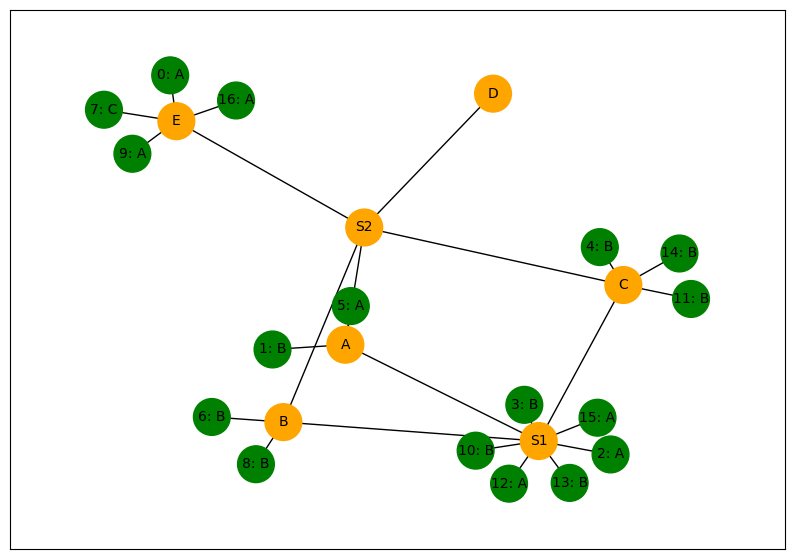

In [668]:
plt.figure(figsize =(10, 7))

pos = nx.kamada_kawai_layout(G,)
nx.draw_networkx_nodes(G, pos, node_size=700, margins=0.1, node_color=color_nodes)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")